In [433]:
import string
import re
import os
import math
import pickle
import copy
import random
import bz2
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from tqdm import tqdm

### Loading the required pickle files

In [434]:
Picklefile1 = open('list_dictionary_tf_idf_features', 'rb')
list_dict_feat_tf_idf = pickle.load(Picklefile1)

Picklefile2 = open('files_list', 'rb')
files = pickle.load(Picklefile2)

Picklefile3 = open('dictionary_doc_mapping', 'rb')
dict_folder_doc_mapping = pickle.load(Picklefile3)

Picklefile4 = open('dictionary_master', 'rb')
mstr_dict_dict = pickle.load(Picklefile4)

Picklefile5 = open('list_dictionary_tf_class', 'rb')
list_dict_dict_tf_class = pickle.load(Picklefile5)

Picklefile6 = open('dictionary_doc_lemmas', 'rb')
dict_doc_lemmas = pickle.load(Picklefile6)

Picklefile7 = open('list_dictionary_mi_features', 'rb')
list_dict_feat_mi = pickle.load(Picklefile7)

Picklefile10 = open('list_list_training_documents', 'rb')
list_list_train_docs = pickle.load(Picklefile10)

Picklefile11 = open('list_list_testing_documents', 'rb')
list_list_test_docs = pickle.load(Picklefile11)

In [435]:
count_total_docs = len(mstr_dict_dict)
list_all_doc_ids = list(mstr_dict_dict.keys())

### Defining the function to train the Naive Bayes classifier accrding to the feature set

In [436]:
def train_naive_bayes(list_train_docs, dict_dict_tf_class):
    count_train_docs = len(list_train_docs)
    global dict_values_prior 
    dict_values_prior = {}
    dict_nc_values = {}
    global dict_prob_tc
    dict_prob_tc = {}
    for e in files:
        dict_nc_values[e] = 0
    
    #Now finding the no. of docs of each class in the training set so as to find the prior value
    for f in list_train_docs:
        mapped_folder = dict_folder_doc_mapping[f]
        dict_nc_values[mapped_folder] += 1
    
    for g in files:
        dict_prob_tc[g] = {}
        value_prior = dict_nc_values[g] / count_train_docs
        dict_values_prior[g] = value_prior
        value_summation_tct = 0
        dict_values_tct = {}
        #Now finding the probability values for the terms present in the complete feature set
        for h in list_vocab_features:
            value_tct = dict_dict_tf_class[g][h]
            value_summation_tct += value_tct
            dict_values_tct[h] = value_tct
        
        for i in dict_values_tct:
            dict_prob_tc[g][i] = (dict_values_tct[i] + 1) / (value_summation_tct + count_vocab_features)

### Defing the function to assign documents to a class according to the trained Naive Bayes classifier.

In [437]:
def test_naive_bayes(list_test_docs):
    global dict_predicted_class
    dict_predicted_class = {}
    #For all test docs finding the predicted class according to the score obtained
    for l in list_test_docs:
        list_tokens = dict_doc_lemmas[l]
        list_scores = []
        #Finding the score of the document with each class 
        for m in files:
            value_score = math.log10(dict_values_prior[m])
            #Only terms of doc present in feature set are used to find score
            for n in list_tokens:
                if dict_feature_boolean.get(n) is not None:
                    value_score += dict_prob_tc[m][n]
            list_scores.append(value_score)
        
        idx_pred_class = list_scores.index(max(list_scores))
        dict_predicted_class[l] = files[idx_pred_class]

### Defining the function to print the confusion matrix and the accuracy obtained.

In [438]:
def confusion_matrix_accuracy():
    list_labels_actual = []
    list_labels_predicted = []
    global value_accuracy
    for o in dict_predicted_class:
        list_labels_actual.append(dict_folder_doc_mapping[o])
        list_labels_predicted.append(dict_predicted_class[o])
    
    print("The confusion matrix is:")
    print(confusion_matrix(list_labels_actual, list_labels_predicted))
    print("The accuracy score is:")
    value_accuracy = accuracy_score(list_labels_actual, list_labels_predicted)
    print(value_accuracy)

### Defining the function to make the complete feature set by doing the union of the features obtained for each class.

In [439]:
def make_features_vocab():
    list_all_features = []
    #Finding the union of features of all classes
    for d in dict_features_list:
        list_all_features.extend(dict_features_list[d][:count_selected_features])
    
    global list_vocab_features
    list_vocab_features = list(set(list_all_features))
    global dict_feature_boolean
    dict_feature_boolean = {}
    for zx in list_vocab_features:
        dict_feature_boolean[zx] = 1
    global count_vocab_features
    count_vocab_features = len(list_vocab_features)

### Calling the funcions defined above for the different split ratios

In [440]:
count_selected_features = 100
list_splits = [[50, 50],[70, 30],[80, 20]]
list_accuracy_tfidf = []
list_accuracy_mi = []

for s in range(len(list_splits)):
    list_docs_train = list_list_train_docs[s]
    list_docs_test = list_list_test_docs[s]
    dict_features_list = list_dict_feat_tf_idf[s]
    make_features_vocab()
    train_naive_bayes(list_docs_train, list_dict_dict_tf_class[s])
    test_naive_bayes(list_docs_test)
    print(f"\nFor {list_splits[s][0]}:{list_splits[s][1]} using tf-idf features :")
    confusion_matrix_accuracy()
    list_accuracy_tfidf.append(value_accuracy)
    
    dict_features_list = list_dict_feat_mi[s]
    make_features_vocab()
    train_naive_bayes(list_docs_train, list_dict_dict_tf_class[s])
    test_naive_bayes(list_docs_test)
    print(f"\nFor {list_splits[s][0]}:{list_splits[s][1]} using mutual independence features :")
    confusion_matrix_accuracy()
    list_accuracy_mi.append(value_accuracy)


For 50:50 using tf-idf features :
The confusion matrix is:
[[187   0   2 313   0]
 [  0 398   2 111   1]
 [  1   0 258 232   5]
 [  1   0   1 485   2]
 [  0   2   6 200 293]]
The accuracy score is:
0.6484

For 50:50 using mutual independence features :
The confusion matrix is:
[[288  11   3 200   0]
 [  0 479   0  31   2]
 [  3   7 325 155   6]
 [  0  10   1 477   1]
 [  5  12   9 151 324]]
The accuracy score is:
0.7572

For 70:30 using tf-idf features :
The confusion matrix is:
[[128 175   0   0   0]
 [  0 282   0   0   0]
 [  0 165 137   0   3]
 [  3 156   1 145   4]
 [  0 122   2   1 176]]
The accuracy score is:
0.5786666666666667

For 70:30 using mutual independence features :
The confusion matrix is:
[[171 121   0  11   0]
 [  0 282   0   0   0]
 [  1 117 176   7   4]
 [  0  57   2 250   0]
 [  0 100   3   8 190]]
The accuracy score is:
0.7126666666666667

For 80:20 using tf-idf features :
The confusion matrix is:
[[ 64   0 149   1   0]
 [  0 158  47   0   0]
 [  0   0 178   0   

### Plotting a graph for split ratio vs accuracy obtained

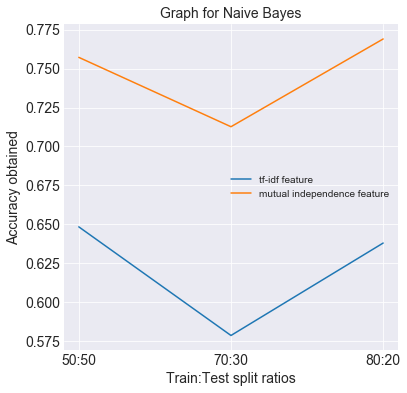

In [441]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6,6))

list_x_cord = ['50:50', '70:30', '80:20']
plt.plot(list_x_cord, list_accuracy_tfidf, label = 'tf-idf feature')
plt.plot(list_x_cord, list_accuracy_mi, label = 'mutual independence feature' )
plt.xlabel('Train:Test split ratios', fontsize = 14)
plt.ylabel('Accuracy obtained', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label = 'Graph for Naive Bayes',fontsize = 14 )
plt.legend()
plt.show()

### Plotting a graph to compare the accuracies obtained using KNN and Naive for different split ratios using tf-idf based feature extraction

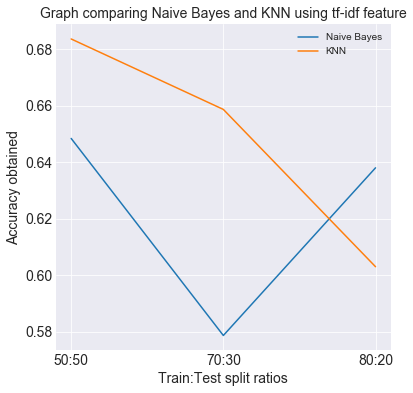

In [442]:
Picklefile13 = open('list_accuracies_tfidf_splits', 'rb')
list_tfidf_acc_2 = pickle.load(Picklefile13)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6,6))

list_x_cord = ['50:50', '70:30', '80:20']
plt.plot(list_x_cord, list_accuracy_tfidf, label = 'Naive Bayes')
plt.plot(list_x_cord, list_tfidf_acc_2, label = 'KNN' )
plt.xlabel('Train:Test split ratios', fontsize = 14)
plt.ylabel('Accuracy obtained', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label = 'Graph comparing Naive Bayes and KNN using tf-idf feature',fontsize = 14 )
plt.legend()
plt.show()

### Plotting a graph to compare the accuracies obtained using KNN and Naive for different split ratios using mutual independence based feature extraction

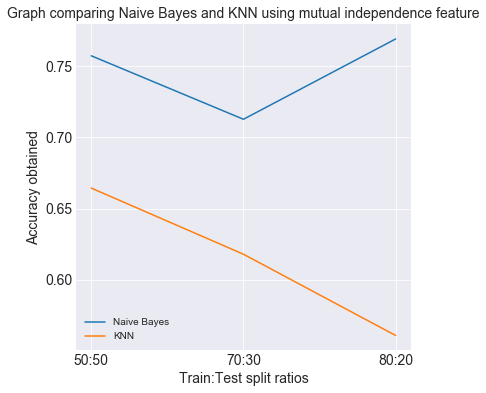

In [443]:
Picklefile14 = open('list_accuracies_mi_splits', 'rb')
list_mi_acc_2 = pickle.load(Picklefile14)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6,6))

list_x_cord = ['50:50', '70:30', '80:20']
plt.plot(list_x_cord, list_accuracy_mi, label = 'Naive Bayes')
plt.plot(list_x_cord, list_mi_acc_2, label = 'KNN' )
plt.xlabel('Train:Test split ratios', fontsize = 14)
plt.ylabel('Accuracy obtained', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label = 'Graph comparing Naive Bayes and KNN using mutual independence feature',fontsize = 14 )
plt.legend()
plt.show()